In [2]:
import os
import glob
import pickle
import string
from tqdm.notebook import tqdm

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider
import matplotlib.colors as mcolors


In [3]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [4]:
master = pd.read_excel('/mnt/c/Users/conor/OneDrive/Desktop/master_xl_1507.xlsx')
gb = list(master.groupby('REF'))

# Plots for Caroline

In [120]:
for name, row in gb:

    break

    fig, axes = plt.subplots(ncols=3, figsize=(15,5))

    he = matplotlib.image.imread(row.iloc[0,1])
    ann = matplotlib.image.imread(row.iloc[0,4])
    ftir = pd.read_hdf(row.iloc[0,5], key='Data').values.reshape(256,256,-1)[:,:,195]

    fig.suptitle(name)

    for ax, im, tit in zip(axes.flatten(), [he, ann, ftir], ['H&E', 'Annotation', 'Amide 1']):

        ax.imshow(im, aspect='auto')
        ax.set_title(tit)

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Plots_September/{name}.pdf', bbox_inches='tight')
    plt.close(fig)

# Annotation Plot

<ipython-input-121-d7fcd772afe8>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


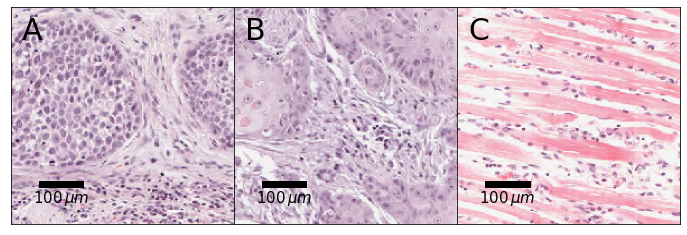

In [121]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4), constrained_layout = True)
fig.subplots_adjust(wspace=0)
[(ax.set_xticks([]), ax.set_yticks([])) for ax in axes];

sbx, sby = 0.1, 0.1
sb = 100

for let, ax, (indx, row) in zip(string.ascii_uppercase, axes.flatten(), master.sample(3).iterrows()):

    he = matplotlib.image.imread(row['HE'])

    ax.imshow(he[200:400, 200:400], aspect='auto')
    ax.text(0.05, 0.85, let, size=30.0, transform=ax.transAxes)
    ax.add_patch(Rectangle((sbx+0.025, sby+0.07), 0.2, 0.03, color='black', transform=ax.transAxes))
    ax.text(sbx, sby, f'${sb}\/\mu m$', size=15.0, transform=ax.transAxes)

fig.savefig('./Annotation.pdf', bbox_inches='tight')

# Complex Permittivity

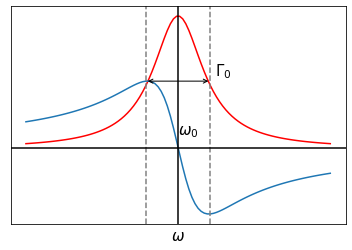

In [122]:
def real_permit(x, wi, gamma):

    y = ((wi**2 - x**2)/((wi**2 - x**2)**2 + (gamma**2*x**2)))

    return y

def complex_permit(x, wi, gamma):

    y = (x*gamma)/((wi**2 - x**2)**2 + (gamma**2*x**2))

    return y

x = np.linspace(-0.5,0.5,100)

yr = real_permit(x, wi=1, gamma=-10) #+ real_permit(x, wi=0.5, gamma=0.005)
yc = complex_permit(x, wi=1, gamma=-10)# + complex_permit(x, wi=0.5, gamma=1)

fig, ax = plt.subplots(1)

ax.plot(x, yr, c='r')
ax.plot(x, yc)

ax.set_xlabel('$\omega$', size=15.0)
ax.axvline(0, c='black', ls='-')

ax.axvline(x[np.argmin(yc)], c='gray', ls='--')
ax.axvline(x[np.argmax(yc)], c='gray', ls='--')

ax.axhline(0, c='black')
ax.annotate("", xy=(x[np.argmin(yc)], np.max(yc)), xytext=(x[np.argmax(yc)], np.max(yc)), arrowprops=dict(arrowstyle="<->"))


ax.text(0, 0.1,'$\omega_0$', c='black', size=15.0)
ax.text(0.12, 0.55,'$\Gamma_0$', c='black', size=15.0)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./Complex_Permittivity.pdf', bbox_inches='tight')


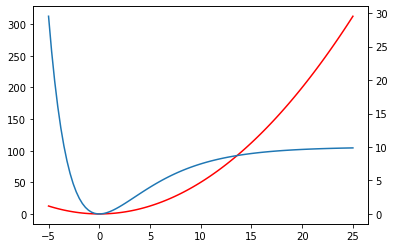

In [123]:
def harmonic_potential(x,k,re):

    y = k*0.5*(x-re)**2# -1 

    return y

def anharmonic_potential(x, a, re, De=10):

    y = De*(1 - np.exp(-a*(x-re)))**2# -1

    return y

x = np.linspace(-5,25,100)

yh = harmonic_potential(x, 1, 0) #+ real_permit(x, wi=0.5, gamma=0.005)
ya = anharmonic_potential(x, 0.2, 0)# + complex_permit(x, wi=0.5, gamma=1)

fig, ax = plt.subplots()

ax.plot(x, yh, c='r')
#ax.plot(x, yc, c='g')

ax2 = ax.twinx()
ax2.plot(x, ya)

#ax.set_xticks([])
#ax.set_yticks([])

#fig.savefig('./Complex_Permittivity.pdf', bbox_inches='tight')


# Spectrum Example Plot

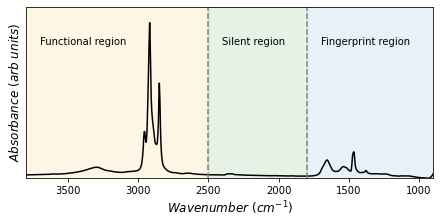

In [124]:
name, row = gb[50]

fig, ax = plt.subplots(figsize=(6,3), constrained_layout = True)

ftir = pd.read_hdf(row.iloc[0,5], key='Data')

mean = ftir.mean(axis=0)

ax.plot(ftir.columns, mean, color='black')
ax.invert_xaxis()
ax.set_xlabel('$Wavenumber\ (cm^{-1})$', fontsize = 12)
ax.set_ylabel('$Absorbance\ (arb\ units)$', fontsize = 12)

ax.axvline(1800, ls='--', ymax=np.max(mean)*1.1, color='gray')

ax.text(1700, 1.5,'Fingerprint region', c='black', size=10.0)
ax.fill_between((1800,np.min(ftir.columns)), y1=np.max(mean)*1.1, alpha=0.1)
ax.axvline(2500, ls='--', ymax=np.max(mean)*1.1, color='gray')

ax.text(2400, 1.5,'Silent region', c='black', size=10.0)
ax.fill_between((2500,1799), y1=np.max(mean)*1.1, alpha=0.1, color='green')

ax.text(3700, 1.5,'Functional region', c='black', size=10.0)
ax.fill_between((np.max(ftir.columns),2499), y1=np.max(mean)*1.1, alpha=0.1, color='orange')

ax.set_xlim(np.max(ftir.columns), np.min(ftir.columns))
ax.set_ylim(np.min(mean), np.max(mean)*1.1)
ax.set_yticks([])

fig.savefig(f'./spectrum_example.pdf', bbox_inches='tight')
#plt.close(fig)

In [125]:
from scipy.fft import dct, idct

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


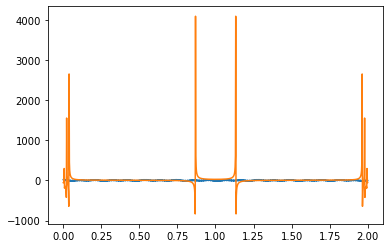

In [126]:
x = np.linspace(0,2,1000)

def intfg(x):

    y = 0

    for a,f in zip([1,4,7,10], [10,34,59, 4500]):

        y  = y + a*np.cos(f*x)
    
    
    return y

y = intfg(x)

plt.plot(x, y)
plt.plot(x, np.fft.fft(y))

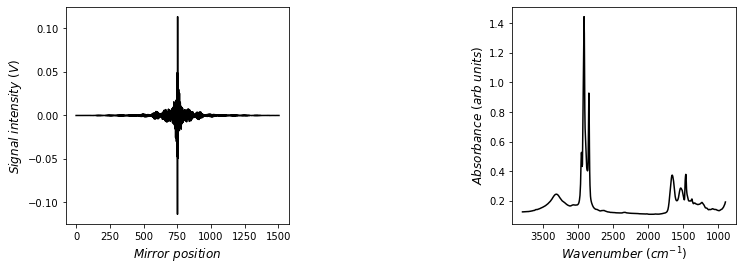

In [127]:
name, row = gb[10]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))

ftir = pd.read_hdf(row.iloc[0,5], key='Data')

mean = ftir.mean(axis=0)
interferogram = idct(mean.values, type=2)
itfg = np.concatenate([-np.flip(interferogram), interferogram], axis=0)

fig.subplots_adjust(wspace=0)

ax1.plot(itfg, color='black')
ax1.set_xlabel('$Mirror\ position$', fontsize = 12)
ax1.set_ylabel('$Signal\ intensity\ (V)$', fontsize = 12)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_frame_on(False)

ax3.plot(mean, color='black')
ax3.invert_xaxis()
ax3.set_xlabel('$Wavenumber\ (cm^{-1})$', fontsize = 12)
ax3.set_ylabel('$Absorbance\ (arb\ units)$', fontsize = 12)


fig.savefig(f'./Interferogram_example.png', bbox_inches='tight')
#plt.close(fig)

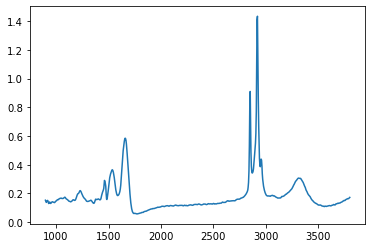

In [128]:
plt.plot(ftir.iloc[50000,:])

<ipython-input-129-dcdaf9608e36>:32: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')


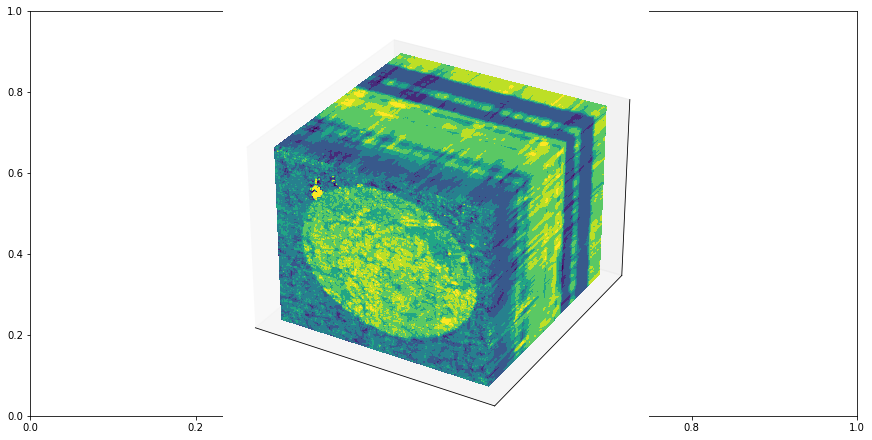

In [129]:
def plot_cube_faces(arr, ax):
    """
    External faces representation of a 3D array with matplotlib

    Parameters
    ----------
    arr: numpy.ndarray()
        3D array to handle
    ax: Axes3D object
        Axis to work with
    """
    x0 = np.arange(arr.shape[0])
    y0 = np.arange(arr.shape[1])
    z0 = np.arange(arr.shape[2])
    x, y, z = np.meshgrid(x0, y0, z0)
    
    xmax, ymax, zmax = max(x0), max(y0), max(z0)
    vmin, vmax = np.min(arr), np.max(arr)

    ax.contourf(x[:, :, 0], y[:, :, 0], arr[:, :, -1].T,
                zdir='z', offset=zmax, vmin=vmin, vmax=vmax)
    ax.contourf(x[0, :, :].T, arr[:, 0, :].T, z[0, :, :].T,
                zdir='y', offset=0, vmin=vmin, vmax=vmax)
    ax.contourf(arr[-1, :, :].T, y[:, 0, :].T, z[:, 0, :].T,
                zdir='x', offset=xmax, vmin=vmin, vmax=vmax)

name, row = gb[0]

fig, ax = plt.subplots(figsize=(12,6), constrained_layout = True)

ftir = pd.read_hdf(row.iloc[0,5], key='Data').iloc[:,26:234]
ax = fig.gca(projection='3d')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

scaled = (ftir.values-ftir.values.mean(axis=0))/ftir.values.std(axis=0)
reshaped = np.moveaxis(scaled.reshape(256,256,-1), 1, -1)

#plot_cube_faces(np.log(np.moveaxis(ftir.values.reshape(256,256,-1),-1,1)-ftir.values.min()+1e-10), ax)
plot_cube_faces(np.clip(reshaped, np.percentile(reshaped, 1), np.percentile(reshaped, 99)), ax)
fig.savefig(f'./Datacube.png', bbox_inches='tight')
#plt.show()

# Classifier Plots

In [7]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [131]:
X, y = make_classification(n_features=2, n_classes=2, n_informative=2, n_redundant=0)

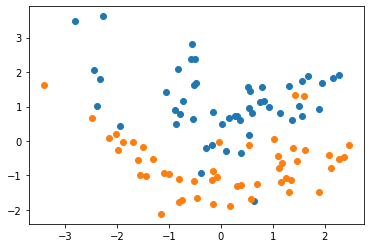

In [132]:
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==0,0], X[y==0,1])

In [133]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
grid_flat = np.stack([xx.flatten(), yy.flatten()],axis=1)

In [134]:
def logistic(x):

    return 1/(1+np.exp(-x))

In [135]:
from scipy.stats import norm

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


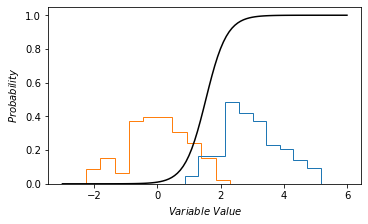

In [136]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout = True)

x1, y1 = norm(0,1).rvs(100), np.ones(100)
x2, y2 = norm(3,1).rvs(100), np.zeros(100)

lr = LogisticRegression()
lr.fit(np.concatenate([x1,x2],axis=0)[:,None], np.concatenate([y1,y2],axis=0)[:,None])

ax.hist(x1, color='tab:orange', density=True, histtype='step')
ax.hist(x2, color='tab:blue', density=True, histtype='step')

x_line = np.linspace(-3,6,100)[:,None]
ax.plot(x_line, lr.predict_proba(x_line)[:,0], color='Black')
ax.set_xlabel('$Variable\ Value$')
ax.set_ylabel('$Probability$')

fig.savefig('./LR_Example.pdf', bbox_inches='tight')

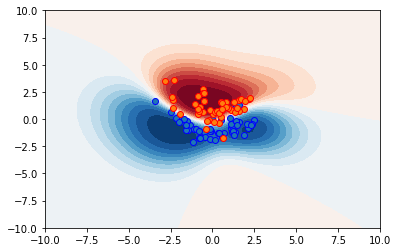

In [137]:
gp = GaussianProcessClassifier(1*RBF(1))
gp.fit(X,y)

grid = gp.predict_proba(grid_flat)

plt.contourf(xx, yy, grid[:,0].reshape(100,100), cmap='RdBu', levels=20)
plt.scatter(X[y==0,0], X[y==0,1], edgecolors='Blue')
plt.scatter(X[y==1,0], X[y==1,1], edgecolors='Red')

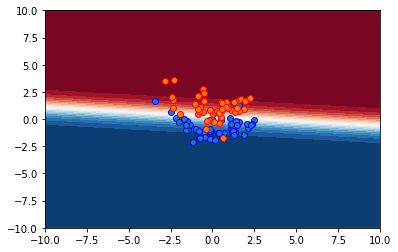

In [138]:
lr = LogisticRegression()
lr.fit(X,y)

grid = lr.predict_proba(grid_flat)

plt.contourf(xx, yy, grid[:,0].reshape(100,100), cmap='RdBu', levels=20)
plt.scatter(X[y==0,0], X[y==0,1], edgecolors='Blue')
plt.scatter(X[y==1,0], X[y==1,1], edgecolors='Red')

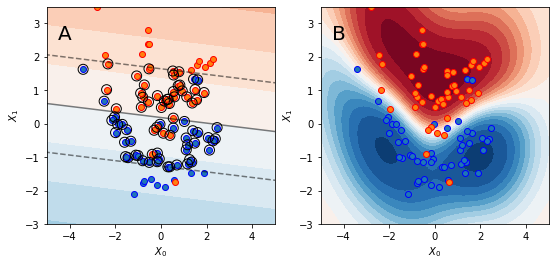

In [139]:
fig, (ax1, ax2)  = plt.subplots(ncols=2,figsize=(9,4))

fig.subplots_adjust(wspace=0.2)

sv = LinearSVC()
sv.fit(X, 1-y)

grid = sv.decision_function(grid_flat)

ax1.contourf(xx, yy, grid.reshape(100,100), cmap='RdBu', levels=20)
ax1.scatter(X[y==0,0], X[y==0,1], edgecolors='Blue')
ax1.scatter(X[y==1,0], X[y==1,1], edgecolors='Red')

decision_function = sv.decision_function(X)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X[support_vector_indices]

Z = sv.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax1.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
ax1.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])

ax1.set_xlim(-5,5)
ax1.set_ylim(-3,3.5)
ax1.set_xlabel('$X_0$')
ax1.set_ylabel('$X_1$')
ax1.text(0.05, 0.85, 'A', size=20.0, transform=ax1.transAxes)

#-------------------------------------------------------------------------------

sv = SVC(probability=True)
sv.fit(X,y)

grid = sv.predict_proba(grid_flat)

ax2.contourf(xx, yy, grid[:,0].reshape(100,100), cmap='RdBu', levels=20)
ax2.scatter(X[y==0,0], X[y==0,1], edgecolors='Blue')
ax2.scatter(X[y==1,0], X[y==1,1], edgecolors='Red')

ax2.set_xlim(-5,5)
ax2.set_ylim(-3,3.5)
ax2.set_xlabel('$X_0$')
ax2.set_ylabel('$X_1$')
#ax2.set_yticks([])
ax2.text(0.05, 0.85, 'B', size=20.0, transform=ax2.transAxes)

fig.savefig('./SVC_Example.pdf', bbox_inches='tight')

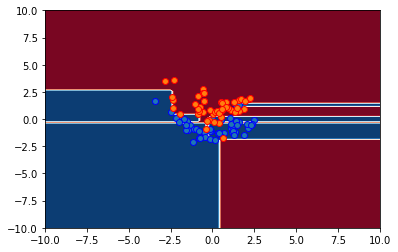

In [140]:
dtc = DecisionTreeClassifier()
dtc.fit(X,y)

grid = dtc.predict_proba(grid_flat)

plt.contourf(xx, yy, grid[:,0].reshape(100,100), cmap='RdBu', levels=20)
plt.scatter(X[y==0,0], X[y==0,1], edgecolors='Blue')
plt.scatter(X[y==1,0], X[y==1,1], edgecolors='Red')

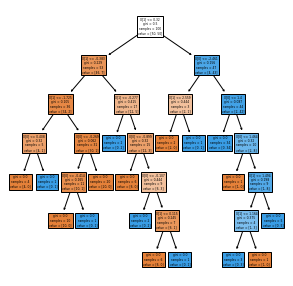

In [141]:
fig, ax = plt.subplots(constrained_layout=False, figsize=(5,5))

tree.plot_tree(dtc,filled=True, ax=ax);

fig.savefig('./Decision_Tree.pdf', bbox_inches='tight')


# Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

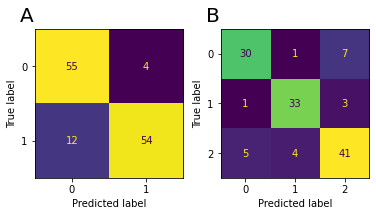

In [143]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.subplots_adjust(wspace=0.25)

## Binary

X, y = make_classification(n_samples=500, n_features=3, n_classes=2, n_informative=3, n_redundant=0)

sv = SVC()

X_train, X_test, y_train, y_test = train_test_split(X, y)

sv.fit(X_train, y_train)

plot_confusion_matrix(sv, X_test, y_test, colorbar=False, ax=ax1)
ax1.text(-0.1, 1.05, 'A', size=20.0, transform=ax1.transAxes)

## Trinary

X, y = make_classification(n_samples=500, n_features=3, n_classes=3, n_informative=3, n_redundant=0)

sv = SVC()

X_train, X_test, y_train, y_test = train_test_split(X, y)

sv.fit(X_train, y_train)

plot_confusion_matrix(sv, X_test, y_test, colorbar=False, ax=ax2)
ax2.text(-0.1, 1.05, 'B', size=20.0, transform=ax2.transAxes)

fig.savefig('./Confusion_Matrix.pdf', bbox_inches='tight')

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


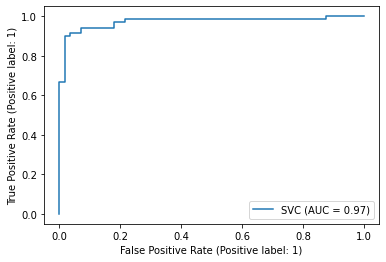

In [9]:
X, y = make_classification(n_samples=500, n_features=3, n_classes=2, n_informative=3, n_redundant=0)

sv = SVC(probability=True)

X_train, X_test, y_train, y_test = train_test_split(X, y)

sv.fit(X_train, y_train)

plot_roc_curve(sv, X_test, y_test)

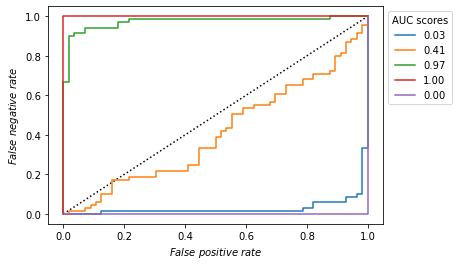

In [10]:
fig, ax = plt.subplots()

g_probs = sv.predict_proba(X_test)[:,0]
b_probs = np.random.random(len(g_probs))
o_probs = 1-g_probs

ax.plot([0,1],[0,1], c='black', ls=':')

for ps in [g_probs, b_probs, o_probs, y_test, 1-y_test]:

    fpr, tpr, thres = roc_curve(y_test, ps)

    auc = roc_auc_score(y_test, ps)

    ax.plot(fpr, tpr, label=f'{auc:.2f}')

ax.set_xlabel('$False\ positive\ rate$')
ax.set_ylabel('$False\ negative\ rate$')
ax.legend(title='AUC scores',bbox_to_anchor=(1,1), loc="upper left")

fig.savefig('./ROC_curves.pdf', bbox_inches='tight')


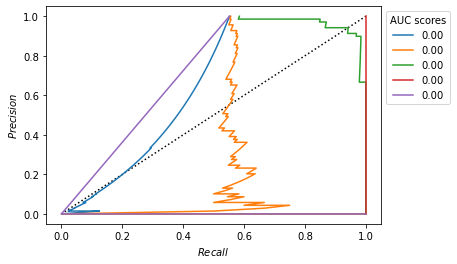

In [18]:
fig, ax = plt.subplots()

g_probs = sv.predict_proba(X_test)[:,0]
b_probs = np.random.random(len(g_probs))
o_probs = 1-g_probs

ax.plot([0,1],[0,1], c='black', ls=':')

for ps in [g_probs, b_probs, o_probs, y_test, 1-y_test]:

    precision, recall, thresholds = precision_recall_curve(y_test, ps)

    #auc = roc_auc_score(y_test, ps)

    ax.plot(precision, recall, label=f'{auc:.2f}')

ax.set_xlabel('$Recall$')
ax.set_ylabel('$Precision$')
ax.legend(title='AUC scores',bbox_to_anchor=(1,1), loc="upper left")

fig.savefig('./ROC_curves.pdf', bbox_inches='tight')
